In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from google.colab.patches import cv2_imshow
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
dir_path = '/content/drive/MyDrive/UGP_EE492A/PSO_results/roi_images/'
output_path =  '/content/drive/MyDrive/UGP_EE492A/PSO_results/roi_results/'

In [4]:
image_path = "/content/drive/MyDrive/UGP_EE492A/PSO_results/roi_images/4.jpg"
image = cv.imread("/content/drive/MyDrive/UGP_EE492A/PSO_results/roi_images/4.jpg")

<ipython-input-5-fb37acf4636c>:26: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  local_otsu = rank.otsu(scaled_image, selem)


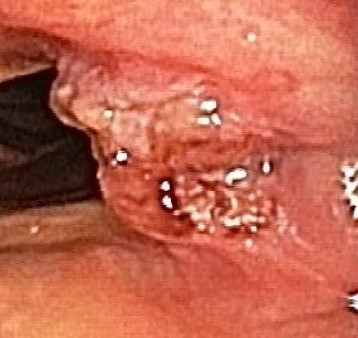

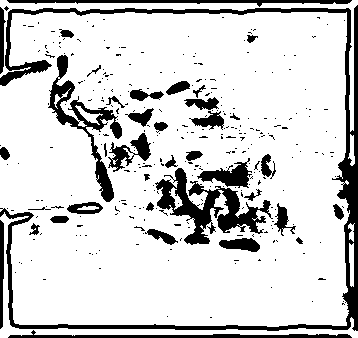

In [5]:
import cv2
import numpy as np
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage.filters import threshold_otsu, rank
from skimage.morphology import disk
import os

def hessian_vesselness(image, sigma):
    H_elems = hessian_matrix(image, sigma=sigma, order='rc')
    _, eigvals = hessian_matrix_eigvals(H_elems)
    return eigvals

def global_otsu_thresholding(image):
    threshold_value = threshold_otsu(image)
    binary_image = image > threshold_value
    return binary_image.astype(np.uint8) * 255

def local_otsu_thresholding(image, radius):
    selem = disk(radius)

    # Scale the input image to the range of -1 to 1
    scaled_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    scaled_image = scaled_image * 2 - 1  # Scale to the range of -1 to 1

    # Apply local Otsu thresholding
    local_otsu = rank.otsu(scaled_image, selem)

    # Convert the resulting binary image to uint8
    binary_image = (scaled_image >= local_otsu).astype(np.uint8) * 255

    return binary_image


def area_thresholding(image, area):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(image, 4, cv2.CV_32S)

    output = np.copy(image)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            if stats[labels[i][j], cv2.CC_STAT_AREA] < area:
                output[i][j] = 0
    return output

def image_fusion(image1, image2):
    fused_image = (image1 + image2) / 2
    return fused_image

def segment_blood_vessels(image_url):
    img = cv2.imread(image_url, cv2.IMREAD_GRAYSCALE)

    # # Vessel Enhancement
    # thin_vessels = hessian_vesselness(img, sigma=1.2)
    # thick_vessels = hessian_vesselness(img, sigma=4)

    thin_vessels = hessian_vesselness(img, sigma=0.2)
    thick_vessels = hessian_vesselness(img, sigma=5.0)

    # Thresholding
    thick_binary = global_otsu_thresholding(1 - thick_vessels)
    thin_binary = global_otsu_thresholding(thin_vessels)

    # Image Fusion
    fused_image = image_fusion(thick_binary, thin_binary)

    # Local Otsu Thresholding
    final_binary = local_otsu_thresholding(fused_image, radius=2.0)

    # Area Thresholding
    final_segmented = area_thresholding(final_binary, area=50)

    return final_segmented

# Example usage:
# image_path = "path_to_your_image.jpg"
segmented_image = segment_blood_vessels(image_path)
cv2_imshow(image)
cv2_imshow(segmented_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [6]:
original_images =[]
output_images =[]

<ipython-input-5-fb37acf4636c>:26: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  local_otsu = rank.otsu(scaled_image, selem)


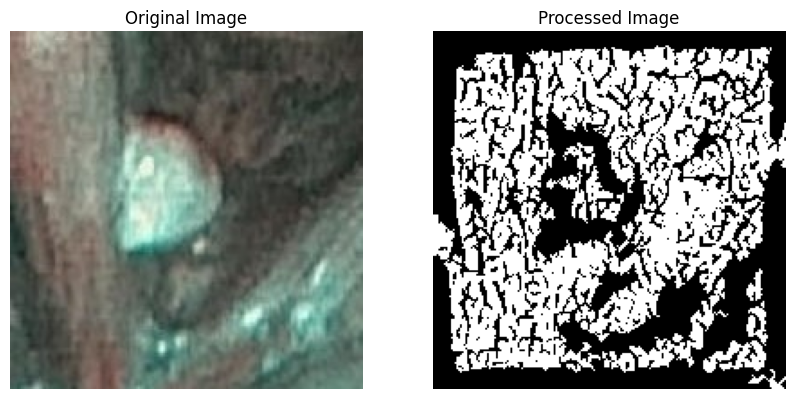

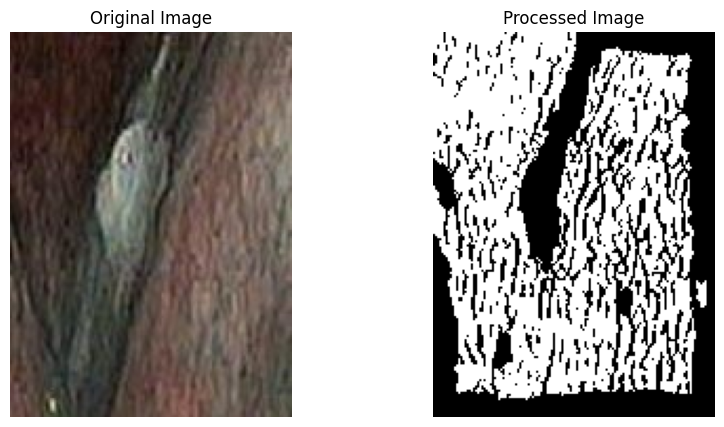

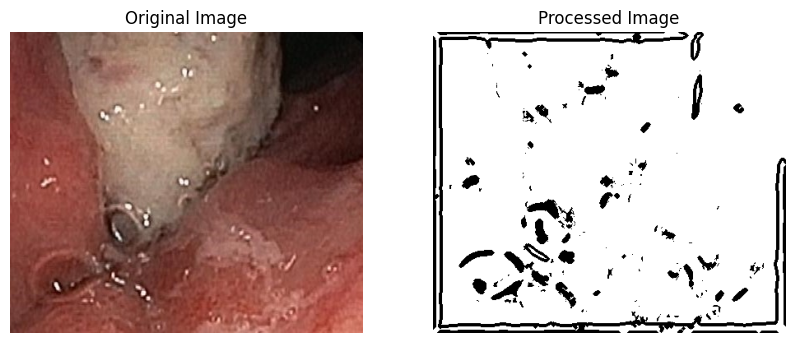

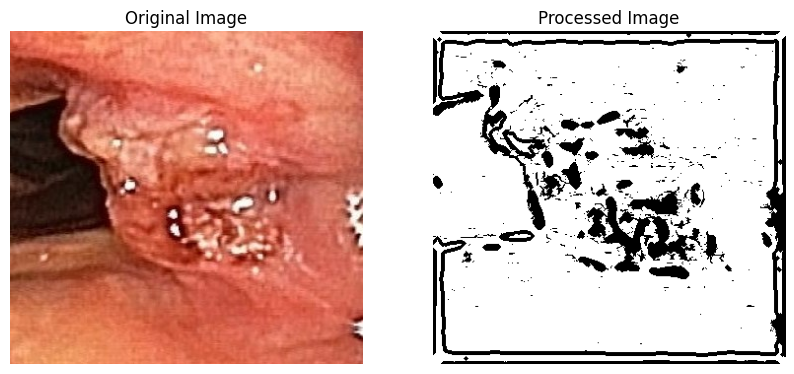

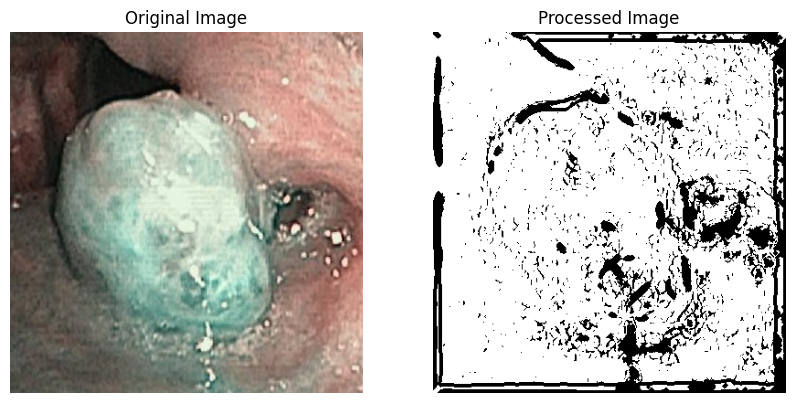

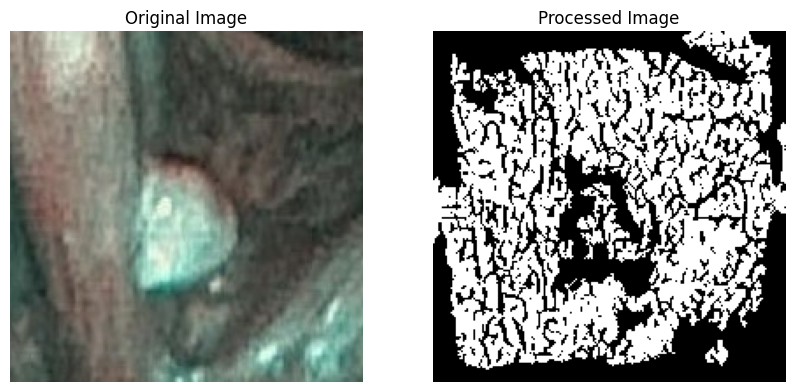

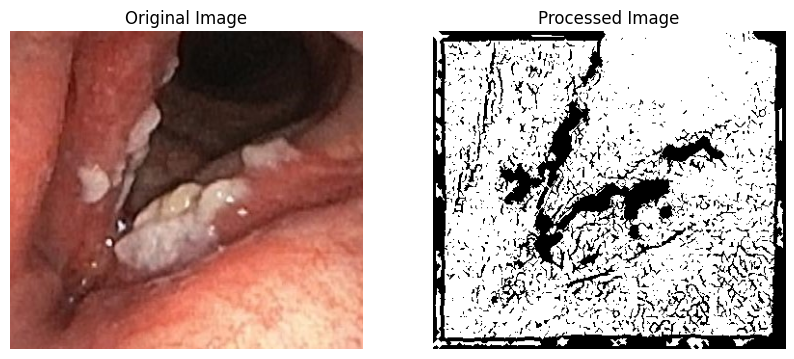

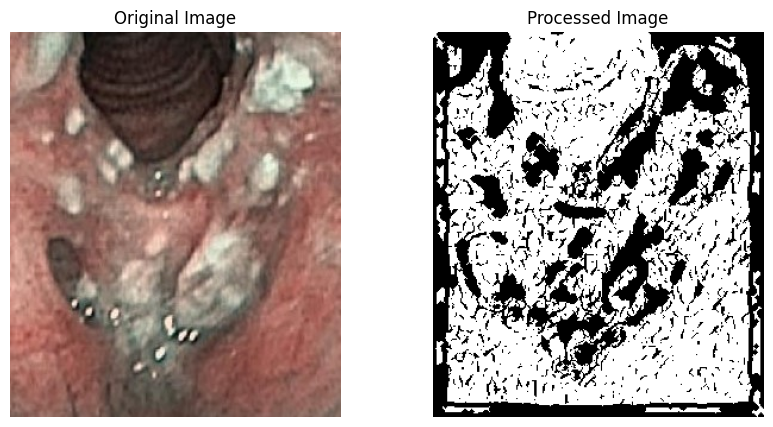

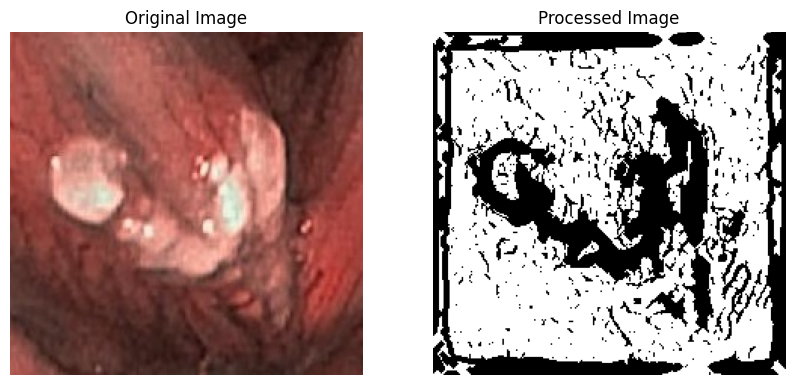

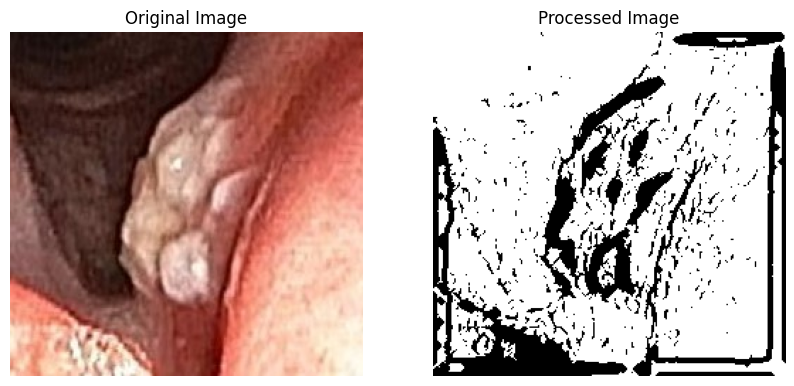

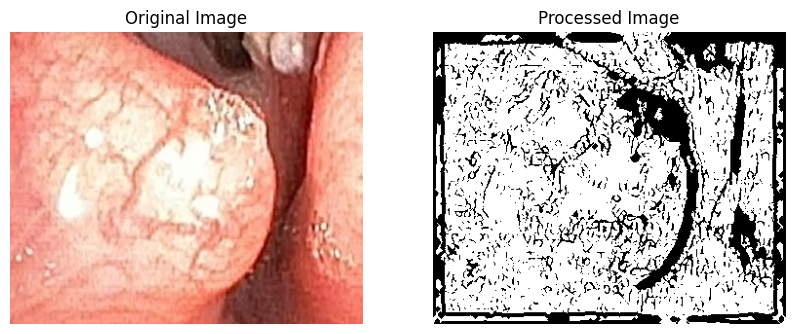

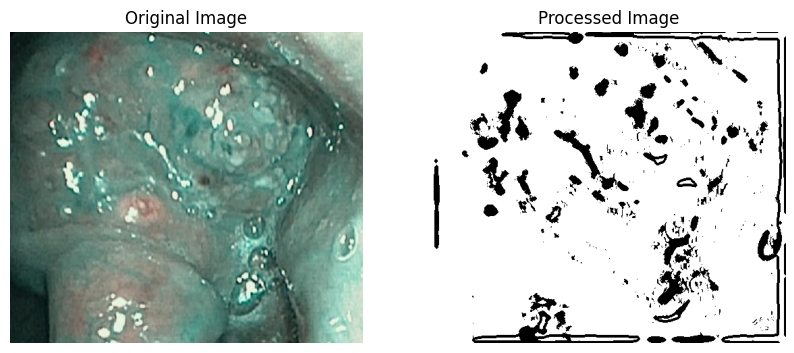

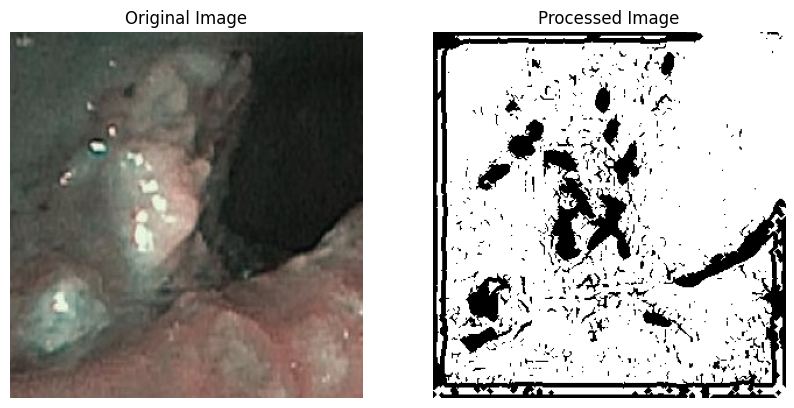

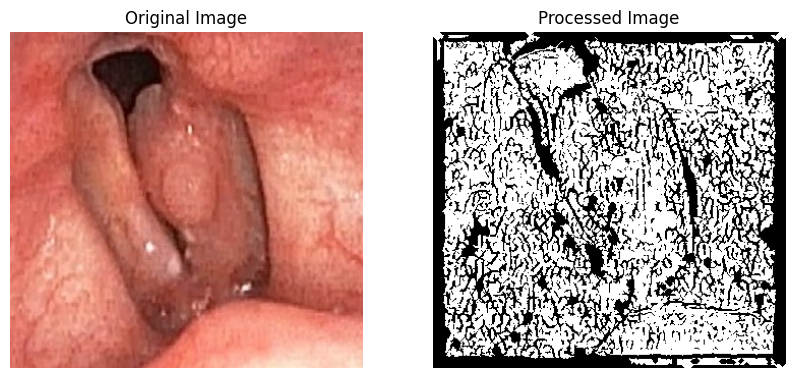

In [7]:
for im in os.listdir(dir_path):

  img = cv.imread(dir_path+im,1)
  original_images.append(img)

  out_img = segment_blood_vessels(dir_path + im)
  output_images.append(out_img)

    # Display img and out_img side by side
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  axes[0].set_title('Original Image')
  axes[0].axis('off')
  axes[1].imshow(out_img, cmap='gray')
  axes[1].set_title('Processed Image')
  axes[1].axis('off')
  plt.show()

  # Save the output image to the output folder
  output_image_path = os.path.join(output_path, im)
  cv.imwrite(output_image_path, out_img)